# Подготовка данных

In [3]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings("ignore")

In [4]:
step_in_the_last = 14   # По скольки шагам в прошлое определяем тренд     ##20,16,16,4
n_steps = 19             # Серию из скольки баров назад анализируем         ##44,42,48,6
forvard_lag = 1         # Предсказание какого бара в будущем делаем       ##1
plato_lvl = 0.00       # Какой разброс цены считать "плато" и приравнивать к 0 в ohe при разметке Y #0
analyze_period = 30000    # Сколько баров в прошлое берем для тренировки модели (чтобы ихбежать тренировки на другой динамике рынка) #3000,2000,1000

### Загрузка и первичная обработка данных

In [5]:
# Загрузка только [Open, High, Low, Close]
data = pd.read_csv('/content/SBER_MIN60.txt', sep="\t", header=None)
data.columns=['Data', 'Open', 'High', 'Low', 'Close']

mask = (data['Data'] >= '2010-09-01 10:00:00.000') & (data['Data'] <= '2018-12-31 23:59:00.000')
data = data[mask]
data

,Data,Open,High,Low,Close
22047,2010-09-01 10:00:00.000,78.55,78.67,77.94,78.04
22048,2010-09-01 11:00:00.000,78.04,78.10,77.60,78.00
22049,2010-09-01 12:00:00.000,78.00,78.88,77.98,78.88
22050,2010-09-01 13:00:00.000,78.89,79.19,78.80,78.85
22051,2010-09-01 14:00:00.000,78.85,78.99,78.61,78.86
...,...,...,...,...,...
40860,2018-12-29 14:00:00.000,186.07,186.08,185.78,185.88
40861,2018-12-29 15:00:00.000,185.88,185.95,185.70,185.70
40862,2018-12-29 16:00:00.000,185.70,186.15,185.70,186.15
40863,2018-12-29 17:00:00.000,186.15,186.35,186.00,186.02


In [6]:
df_data = data.drop(data.columns[[1, 2, 3]], axis='columns') # Оставляем дату и цену, чтобы потом добавить в outputs
del data['Data']

Text(0.5, 1.0, 'График цены на SBER (1h)')

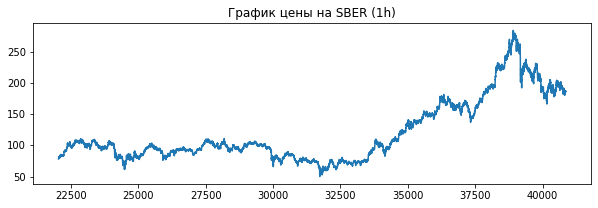

In [7]:
plt.figure(figsize=(10,4))
ax0 = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
#ax1 = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
data['Close'].plot(ax = ax0)
plt.title('График цены на SBER (1h)')
#data[indicator_name].plot(ax = ax1)

In [8]:
# считаем относительную доходность единицах на step_in_the_last шагов назад
for i in range(1, step_in_the_last + 1):
  indicator_name = 'Close_chng_%d' % (i)
  data[indicator_name] = data['Close'].pct_change(i) # относительная доходность единицах

data = data.dropna() # удаляем строки с NaN
print(data.shape)
data[-5:]

(18804, 18)


,Open,High,Low,Close,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5,Close_chng_6,Close_chng_7,Close_chng_8,Close_chng_9,Close_chng_10,Close_chng_11,Close_chng_12,Close_chng_13,Close_chng_14
40860,186.07,186.08,185.78,185.88,-0.001075,0.000969,0.000215,-0.002790,-0.003324,-0.005191,-0.002147,-0.002362,-0.006042,-0.003111,-0.003164,-0.002415,0.002859,0.004757
40861,185.88,185.95,185.70,185.70,-0.000968,-0.002042,0.000000,-0.000753,-0.003755,-0.004290,-0.006155,-0.003114,-0.003328,-0.007005,-0.004076,-0.004129,-0.003381,0.001888
40862,185.70,186.15,185.70,186.15,0.002423,0.001453,0.000376,0.002423,0.001668,-0.001341,-0.001877,-0.003746,-0.000698,-0.000912,-0.004599,-0.001663,-0.001716,-0.000966
40863,186.15,186.35,186.00,186.02,-0.000698,0.001723,0.000753,-0.000322,0.001723,0.000969,-0.002039,-0.002574,-0.004442,-0.001396,-0.001610,-0.005294,-0.002360,-0.002413
40864,186.05,186.49,185.97,186.34,0.001720,0.001021,0.003446,0.002475,0.001397,0.003446,0.002690,-0.000322,-0.000858,-0.002729,0.000322,0.000107,-0.003583,-0.000644


In [9]:
# Добавил разметку направления тренда
for i in range(1, step_in_the_last + 1):
  indicator_name = 'Close_chng_%d' % (i)
  indicator_name_new = 'Y_%d' % (i)
  data[indicator_name_new] = 0
  #data.loc[data[indicator_name] < (0 - plato_lvl), indicator_name_new] = -1
  data.loc[data[indicator_name] > (0 + plato_lvl), indicator_name_new] = 1

for i in range(1, step_in_the_last + 1):
  indicator_name = 'Close_chng_%d' % (i)
  del data[indicator_name]

del data['Open'], data['High'], data['Low']

print(data.shape)
data[-6:]

(18804, 15)


,Close,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7,Y_8,Y_9,Y_10,Y_11,Y_12,Y_13,Y_14
40859,186.08,1,1,0,0,0,0,0,0,0,0,0,1,1,1
40860,185.88,0,1,1,0,0,0,0,0,0,0,0,0,1,1
40861,185.70,0,0,0,0,0,0,0,0,0,0,0,0,0,1
40862,186.15,1,1,1,1,1,0,0,0,0,0,0,0,0,0
40863,186.02,0,1,1,0,1,1,0,0,0,0,0,0,0,0
40864,186.34,1,1,1,1,1,1,1,0,0,0,1,1,0,0


## Выделяем Y

In [10]:
indicator_name = 'Y_%d' % (step_in_the_last)
data_Y = data[indicator_name]
data_Y[-6:]

40859    1
40860    1
40861    1
40862    0
40863    0
40864    0
Name: Y_14, dtype: int64

In [11]:
# превожу в to_categorical
from keras.utils import to_categorical
categorical_labels = to_categorical(data_Y, num_classes = 2)
print(len(categorical_labels))
categorical_labels[-6:]

18804


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Делим на обучающую, тестовую и валидационную выборки

### Деление на выборки train, test, val

In [12]:
data = data.values
print(data.shape, type(data))

(18804, 15) <class 'numpy.ndarray'>


In [13]:
# берем для xTest последние 600 значений
n_train = 600
xTrain = data[:-n_train]
xTest = data[-n_train:]
yTrain = categorical_labels[:-n_train]
yTest = categorical_labels[-n_train:]

print('xTrain: ', xTrain.shape, '\tyTrain:', yTrain.shape,
      '\nxTest:  ', xTest.shape, '\tyTest: ', yTest.shape)
xTrain.shape[0]+xTest.shape[0]

xTrain:  (18204, 15) 	yTrain: (18204, 2) 
xTest:   (600, 15) 	yTest:  (600, 2)


18804

In [14]:
data[-n_train:][-1] # последняя подаваемая строка

array([186.34,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
         0.  ,   0.  ,   0.  ,   1.  ,   1.  ,   0.  ,   0.  ])

### Скалирование Х

In [15]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler # проверить все
""" 
# Масштабируем только X
"""
#xScaler = StandardScaler()
xScaler = RobustScaler()
#xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

print(xTrain.shape, xTest.shape, type(xTrain))
xTest[-1:]

(18204, 15) (600, 15) <class 'numpy.ndarray'>


array([[ 1.42205261,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -1.        , -1.        ,
        -1.        ,  0.        ,  0.        , -1.        , -1.        ]])

In [16]:
# проверяю обратную трансформацию
x = xScaler.inverse_transform(xTest[-1:])
x[-1][0]

186.34

### Превращение в TimeSeries

In [17]:
"""
#### Функция разделения массива на выборки для обучения нейросети 
"""
# sequence = строка массива df
# n_steps = число баров в прошлом для анализа - необходимо найти оптимальный!!
# forvard_lag = предсказание какого бара в будущем делаем 

def split_sequence(sequence, Y, n_steps, forvard_lag):
  # sequence = df.values - это массив из данных
  # n_steps = число баров в прошлом для анализа
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps # находим конечный индекс строки
    if end_ix + (forvard_lag-1) > len(sequence)-1: # cпроверем чтобы не выйти за пределы массива
      break 
    # получаем X и y
    seq_x, seq_y = sequence[i:end_ix], Y[end_ix + (forvard_lag - 1)]
    X.append(seq_x)
    y.append(seq_y) # тк предсказываем только Close
  return array(X), array(y)

In [18]:
"""
# Число баров в прошлом для анализа - место для эксперимента от 0 до 90
"""
#for i in [forvard_lag, 0, 0]:
for i in [forvard_lag]:
  # Формируем выборки для обучения нейросети
  xTrain, yTrain = split_sequence(xTrain, yTrain, n_steps, forvard_lag=i)

  print('\nОбратите внимание на потерянные n_steps данных в начале выборки:')
  print('Массивы xTrain и yTrain:\t', xTrain.shape, yTrain.shape)

#y[97:102], X[97:102]  # чтобы проверить наличие сдвига


Обратите внимание на потерянные n_steps данных в начале выборки:
Массивы xTrain и yTrain:	 (18185, 19, 15) (18185, 2)


In [19]:
"""
# Число баров в прошлом для анализа - место для эксперимента от 0 до 90
"""
#for i in [forvard_lag, 0, 0]:
for i in [forvard_lag]:
  # Формируем выборки для обучения нейросети
  xTest, yTest = split_sequence(xTest, yTest, n_steps, forvard_lag=i)

  print('\nОбратите внимание на потерянные n_steps данных в начале выборки:')
  print('Массивы xTest и yTest:\t', xTest.shape, yTest.shape)

#y[97:102], X[97:102]  # чтобы проверить наличие сдвига


Обратите внимание на потерянные n_steps данных в начале выборки:
Массивы xTest и yTest:	 (581, 19, 15) (581, 2)


# Нейросети

In [20]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, 
                                     GRU, LSTM, Bidirectional, Conv1D, SeparableConv1D, MaxPooling1D,
                                     Reshape, RepeatVector, SpatialDropout1D, LeakyReLU, Embedding)
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils
from keras.utils import plot_model
from IPython.display import clear_output

###Conv1D

In [48]:
# -----------------------------
# Conv1D = создаем модель
# -----------------------------

# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
  
drop = 0.4
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))

x = Flatten()(input)
x = RepeatVector(4)(x)
x = Conv1D(n_steps*2, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = RepeatVector(4)(x)
x = Conv1D(n_steps, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(n_steps*100, activation='relu')(x)
x = Dropout(drop)(x)
x = Dense(yTrain.shape[1], activation='sigmoid')(x)
model = Model(input, x)

#print(model.summary()) #Вывод структуры модели
#plot_model(model, dpi=50, show_shapes=True, show_layer_names=True)


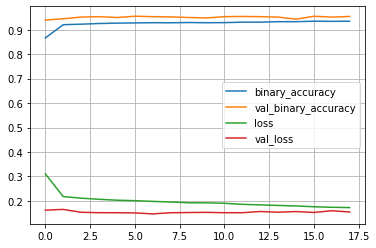

In [49]:
#xTrain , yTrain = X, y # если не используется TimeSeries
model.compile(optimizer=Adam(learning_rate = 5e-05),
              loss='binary_crossentropy',
              metrics=['binary_accuracy']) 

# коллбэки
early_stopping = EarlyStopping(monitor = 'val_binary_accuracy', patience = 12, verbose = 0, 
                               restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 1)
checkpoint = ModelCheckpoint('_SBER_Conv_1h_Up.h5', monitor='val_binary_accuracy', verbose = 1,
                             save_best_only = True, mode='max')

# fit model
history = model.fit(xTrain, yTrain, epochs=200, verbose = 0,
                    validation_data=(xTest, yTest),
                    #batch_size = 1,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

clear_output()
plt.figure(figsize=(6,4))
plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [50]:
model = load_model('_SBER_Conv_1h_Up.h5')

# От себя добавил цикл для распознавания всех тестовых вариантов и вывода класса
x_test = xTest[-200:]
y_test_org = yTest[-200:]
conv_test = []
for i in range(len(x_test)):   # Выбираю пример
  x = x_test[i]
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) # Распознаём наш пример
  #print('\n',prediction)
  prediction = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)

  if prediction == np.argmax(y_test_org[i]):
    conv_test.append('True')
  else:
    conv_test.append('False')

  print('Index:', i, '\tPrediction:', prediction, 'Real:', np.argmax(y_test_org[i]),
        '\t====>', y_test_org[i])

#clear_output()
from collections import Counter
accuracyConv = Counter(conv_test)
print(accuracyConv)

Index: 0 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 1 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 2 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 3 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 4 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 5 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 6 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 7 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 8 	Prediction: 0 Real: 0 	====> [1. 0.]
Index: 9 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 10 	Prediction: 0 Real: 1 	====> [0. 1.]
Index: 11 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 12 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 13 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 14 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 15 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 16 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 17 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 18 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 19 	Prediction: 1 Real: 1 	====> [0. 1.]
Index: 20 	Prediction: 1 Real: 1 	====> [0. 1.]
In

###GRU



In [24]:
# -----------------------------
# GRU = создаем модель
# -----------------------------

drop = 0.2
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))

# xTrain.shape[1] - число шагов назад для обучения (n_steps)
# xTrain.shape[2] - число столбцов в обучающей выборке

x = GRU(xTrain.shape[1] * xTrain.shape[1], dropout=drop)(input)
x = RepeatVector(xTrain.shape[1])(x)
x = GRU(xTrain.shape[1] * xTrain.shape[1], dropout=drop)(x)

x = Dense(yTrain.shape[1], activation='sigmoid')(x)
model = Model(input, x)

#print(model.summary())

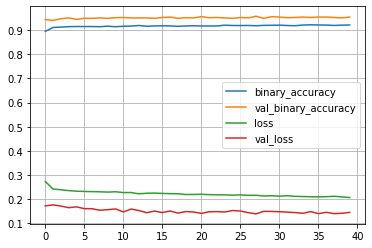

In [25]:
#xTrain , yTrain = X, y # если не используется TimeSeries
model.compile(optimizer=Adam(learning_rate = 1e-04),
              loss='binary_crossentropy',
              metrics=['binary_accuracy']) 

# коллбэки
early_stopping = EarlyStopping(monitor = 'val_binary_accuracy', patience = 12, verbose = 0, 
                               restore_best_weights = True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 1)
checkpoint = ModelCheckpoint('_SBER_GRU_1h_Up.h5', monitor='val_binary_accuracy', verbose = 1,
                             save_best_only = True, mode='max')

# fit model
history = model.fit(xTrain, yTrain, epochs=200, verbose=0,
                    validation_data=(xTest, yTest),
                    #batch_size = 1,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

clear_output()
plt.figure(figsize=(6,4))
plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [26]:
model = load_model('_SBER_GRU_1h_Up.h5')

x_test = xTest[-200:]
y_test_org = yTest[-200:]
lstm_test = []
for i in range(len(x_test)):   # Выбираю пример
  x = x_test[i]
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) # Распознаём наш пример
  #print('\n',prediction)
  prediction = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)

  if prediction == np.argmax(y_test_org[i]):
    lstm_test.append('True')
  else:
    lstm_test.append('False')

  print('Index:', i, '\tPrediction:', prediction, 'Real:', np.argmax(y_test_org[i]),
        '\t====>', y_test_org[i])


clear_output()
from collections import Counter
accuracyLSTM = Counter(lstm_test)
print(accuracyLSTM)

Counter({'True': 191, 'False': 9})


# Моделирование торговли

In [27]:
from IPython.display import clear_output
from tensorflow.keras.models import load_model

### Функции моделирования торговли и отрисовки графиков

In [33]:
def trading(model, xTest):
  x_test = xTest
  returns = pd.DataFrame()
  statement = 0 #  {0:in_cash, 1:long, 2:short}
  stock = 0.   # Число акций
  cash = 1000000.   # Стартовая сумма капитала
  # -----------------------------------------

  for i in range(len(x_test)):   # Выбираю пример
    x = x_test[i]
    x = np.expand_dims(x, axis=0)
    prediction = model.predict(x) # Распознаём наш пример  == {0:stay, 1:up, 2:down}
    signal = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)
    close = xScaler.inverse_transform(x_test[i])
    close = close[-1][0]

    if statement == 0  and  signal == 1:
      statement = 1
      capital = cash//close * close + cash - cash//close * close
      inv_capital = cash//close * close
      line = pd.DataFrame({'statement':[0], 'signal':[signal], 'close':[close],'stock':[cash//close], 'deal_prise':[close],
                           'long':[close*0.9], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash - cash//close * close],
                           'capital':[capital], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue
  

    elif statement == 0  and  signal == 0:
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close],'stock':[0],  'deal_prise':[0],
                           'long':[0], 'short':[0], 'inv_capital':[0], 'cash':[cash], 'capital':[cash], 'ret(i)':[0] })

      returns = returns.append(line, ignore_index=True)
      continue
      
      
    elif statement == 1  and  signal == 1:
      stock = returns.iloc[i-1][3]
      cash = returns.iloc[i-1][8]
      inv_capital = close*stock
      capital = close*stock+cash
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[returns.iloc[i-1][4]],
                           'long':[0], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash],  'capital':[capital], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue


    elif statement == 1  and  signal == 0:    ## выходим в кэш!
      statement = 0
      stock = returns.iloc[i-1][3]
      ret = (close - returns.iloc[i-1][4]) * stock
      capital = close * stock + returns.iloc[i-1][8]
      stock = 0
      inv_capital = close*stock
      cash = capital - inv_capital
      line = pd.DataFrame({'statement':[1], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[close],
                           'long':[0], 'short':[close*1.1], 'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[ret] })
      returns = returns.append(line, ignore_index=True)
      continue

  return returns


In [44]:
def plotting(returns):
  short = returns['short'].values
  short = short.astype(bool)
  long = returns['long'].values
  long = long.astype(bool)
  idx_long = np.where(long) 
  idx_short = np.where(short) 

  plt.figure(figsize=(18,5))

  plt.subplot(121)
  plt.plot(returns['close'], alpha=0.6)
  plt.plot(idx_long, returns['close'].values[[idx_long]], '^', c='g')
  plt.plot(idx_short, returns['close'].values[[idx_short]], 'v', c='r', fillstyle='none')
  plt.grid()

  plt.subplot(122)
  plt.plot(returns['capital'])
  plt.grid()
  plt.show()

### Моделирование торговли на тестовой выборке в 600 часовых интервалов

### conv

In [51]:
#%%timeit
file = '_SBER_Conv_1h_Up.h5'
model = load_model(file)
returns = trading(model, xTest)
returns[-5:]

,statement,signal,close,stock,deal_prise,long,short,inv_capital,cash,capital,ret(i)
576,1,1,186.08,6011.0,183.88,0.0,0.00,1118526.88,46.09,1118572.97,0.00
577,1,1,185.88,6011.0,183.88,0.0,0.00,1117324.68,46.09,1117370.77,0.00
578,1,0,185.70,0.0,185.70,0.0,204.27,0.00,1116288.79,1116288.79,10940.02
579,0,0,186.15,0.0,0.00,0.0,0.00,0.00,1116288.79,1116288.79,0.00
580,0,0,186.02,0.0,0.00,0.0,0.00,0.00,1116288.79,1116288.79,0.00


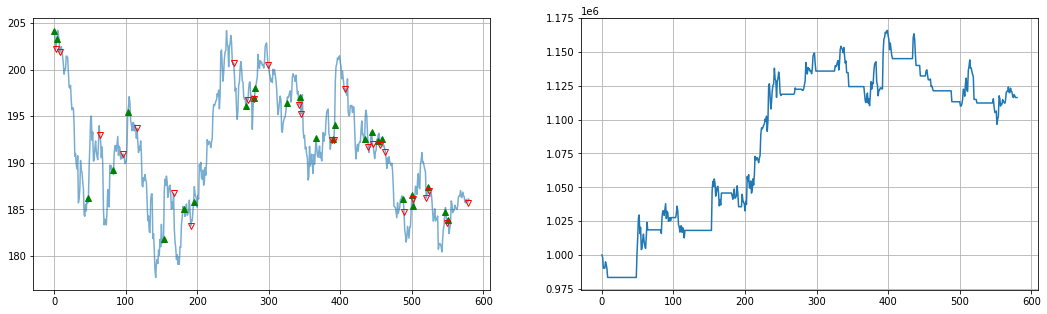

In [52]:
plotting(returns)

### gru

In [40]:
#%%timeit
file = '_SBER_GRU_1h_Up.h5'
model = load_model(file)
returns = trading(model, xTest)
returns[-5:]

,statement,signal,close,stock,deal_prise,long,short,inv_capital,cash,capital,ret(i)
576,1,1,186.08,6098.0,183.88,0.0,0.00,1134715.84,74.65,1134790.49,0.00
577,1,1,185.88,6098.0,183.88,0.0,0.00,1133496.24,74.65,1133570.89,0.00
578,1,0,185.70,0.0,185.70,0.0,204.27,0.00,1132473.25,1132473.25,11098.36
579,0,0,186.15,0.0,0.00,0.0,0.00,0.00,1132473.25,1132473.25,0.00
580,0,0,186.02,0.0,0.00,0.0,0.00,0.00,1132473.25,1132473.25,0.00


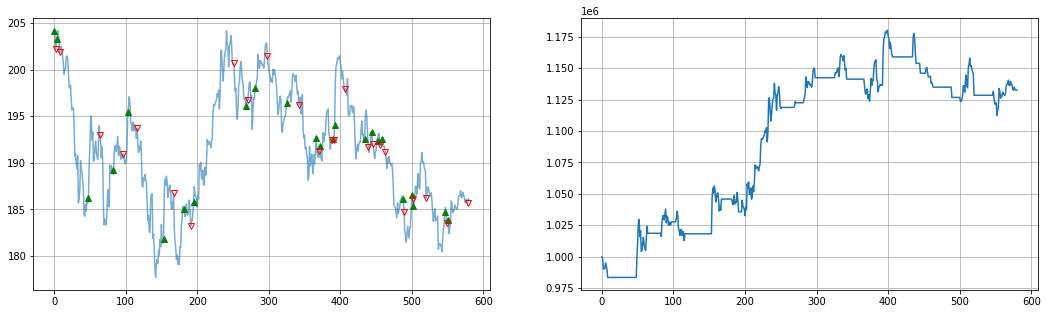

In [45]:
plotting(returns)